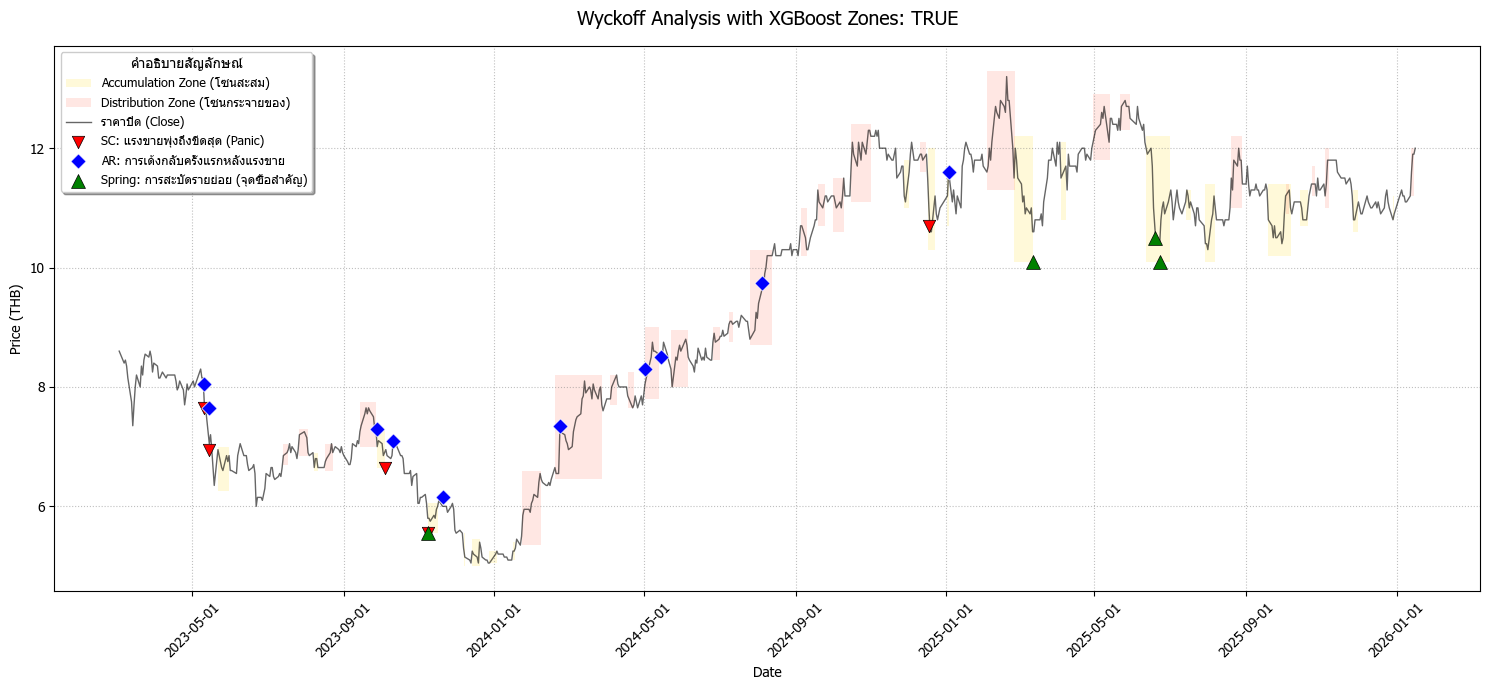

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cassandra.cluster import Cluster
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.dates as mdates   
from datetime import timedelta

# ========================================
# 1. การเชื่อมต่อ Cassandra
# ========================================
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'TRUE'

def get_data(symbol):
    cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
    session = cluster.connect('data_stock')
    query = f"SELECT symbol, time, open, high, low, close, volume FROM candlestick_data WHERE symbol = '{symbol}' LIMIT 3000 ALLOW FILTERING"
    df = pd.DataFrame(list(session.execute(query)))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    cluster.shutdown()
    return df.reset_index(drop=True)

df = get_data(SYMBOL)

# ========================================
# 2. Wyckoff Feature & Event Detection
# ========================================
def detect_wyckoff_advanced(df, window=30):
    df = df.copy()
    df['vol_ma'] = df['volume'].rolling(window=window).mean()
    df['price_spread'] = df['high'] - df['low']
    
    # 1. SC (Selling Climax) & BC (Buying Climax)
    df['SC'] = (df['volume'] > df['vol_ma'] * 3) & (df['low'] == df['low'].rolling(window).min())
    df['BC'] = (df['volume'] > df['vol_ma'] * 3) & (df['high'] == df['high'].rolling(window).max())
    
    # 2. AR (Automatic Rally / Reaction)
    # หาจุดสูงสุด/ต่ำสุด ภายใน 10 แท่งหลังจากเกิด Climax
    df['AR'] = False
    for i in df.index[df['SC'] | df['BC']]:
        if i + 10 < len(df):
            if df.loc[i, 'SC']:
                ar_idx = df.loc[i:i+10, 'high'].idxmax()
                df.at[ar_idx, 'AR'] = True
            else:
                ar_idx = df.loc[i:i+10, 'low'].idxmin()
                df.at[ar_idx, 'AR'] = True

    # 3. Spring Detection
    support = df['low'].rolling(window=60).min().shift(1)
    df['SPRING'] = (df['low'] < support) & (df['close'] > support) & (df['volume'] > df['vol_ma'])
    
    return df

df_wyckoff = detect_wyckoff_advanced(df)

# ========================================
# 3. XGBoost Zone Classification
# ========================================
# สร้าง Label พื้นฐานสำหรับสอน ML (0=Normal, 1=Accumulation, 2=Distribution)
def prepare_ml_data(df):
    data = df.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_change'] = data['volume'].pct_change()
    
    # สร้างเป้าหมาย (Target) สมมติจากความสัมพันธ์ของ MA
    # ในหน้างานจริง ควรใช้ Label จากการตรวจสอบโดยผู้เชี่ยวชาญ
    short_ma = data['close'].rolling(20).mean()
    long_ma = data['close'].rolling(50).mean()
    
    target = []
    for i in range(len(data)):
        if data['close'].iloc[i] < long_ma.iloc[i] and data['volume'].iloc[i] > data['vol_ma'].iloc[i]:
            target.append(1) # Accumulation Zone
        elif data['close'].iloc[i] > long_ma.iloc[i] and data['volume'].iloc[i] > data['vol_ma'].iloc[i]:
            target.append(2) # Distribution Zone
        else:
            target.append(0)
    
    data['target'] = target
    features = ['close', 'volume', 'price_spread', 'vol_ma', 'returns']
    X = data[features].fillna(0)
    y = data['target']
    
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X, y)
    data['zone_pred'] = model.predict(X)
    return data

df_ml = prepare_ml_data(df_wyckoff)

# ========================================
# 4. Visualization: Clean & Precise Wyckoff Dashboard
# ========================================
def plot_wyckoff_zones(df):
    # --- 1. ตั้งค่าฟอนต์ภาษาไทย (สำหรับ Windows) ---
    plt.rcParams['font.family'] = 'Tahoma' 
    plt.rcParams['axes.unicode_minus'] = False
    
    MAIN_TITLE = f"Wyckoff Analysis with XGBoost Zones: {SYMBOL}"
    ACCUM_COLOR = 'gold'
    DIST_COLOR = 'tomato'
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # --- 2. วาดสี่เหลี่ยมโซน (Background) ---
    zone_types = {1: (ACCUM_COLOR, 'Accumulation Zone (โซนสะสม)'), 
                  2: (DIST_COLOR, 'Distribution Zone (โซนกระจายของ)')}
    
    for zone_id, (color, label_name) in zone_types.items():
        subset = df[df['zone_pred'] == zone_id]
        if not subset.empty:
            start_t = subset['time'].iloc[0]
            for i in range(1, len(subset)):
                if (subset['time'].iloc[i] - subset['time'].iloc[i-1]).days > 5 or i == len(subset) - 1:
                    end_t = subset['time'].iloc[i-1]
                    box_data = df[(df['time'] >= start_t) & (df['time'] <= end_t)]
                    if not box_data.empty:
                        # แปลงเวลาเป็นตัวเลขที่ Matplotlib เข้าใจสำหรับการวาด Rectangle
                        rect_start = mdates.date2num(start_t)
                        rect_width = mdates.date2num(end_t) - rect_start
                        
                        rect = patches.Rectangle(
                            (rect_start, box_data['low'].min()), 
                            rect_width, 
                            (box_data['high'].max() - box_data['low'].min()),
                            linewidth=0, facecolor=color, alpha=0.15, label=label_name, zorder=1
                        )
                        ax.add_patch(rect)
                    start_t = subset['time'].iloc[i]

    # --- 3. วาดเส้นราคา ---
    ax.plot(df['time'], df['close'], color='black', alpha=0.6, linewidth=1, label='ราคาปิด (Close)', zorder=3)
    
    # --- 4. มาร์กเหตุการณ์ Wyckoff พร้อมคำอธิบายภาษาไทย ---
    sc = df[df['SC']]
    ar = df[df['AR']]
    spring = df[df['SPRING']]
    
    ax.scatter(sc['time'], sc['low'], color='red', marker='v', s=80, 
               edgecolor='black', linewidth=0.5, 
               label='SC: แรงขายพุ่งถึงขีดสุด (Panic)', zorder=10)
    
    ax.scatter(ar['time'], ar['high'], color='blue', marker='D', s=60, 
               edgecolor='white', linewidth=0.5, 
               label='AR: การเด้งกลับครั้งแรกหลังแรงขาย', zorder=10)

    ax.scatter(spring['time'], spring['low'], color='green', marker='^', s=100, 
               edgecolor='black', linewidth=0.5, 
               label='Spring: การสะบัดรายย่อย (จุดซื้อสำคัญ)', zorder=10)

    # --- 5. จัดการแกน X ให้เป็นวันที่ ---
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # รูปแบบ ปี-เดือน-วัน
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45) # เอียงวันที่เพื่อให้ไม่อัดกันเกินไป

    # --- 6. ปรับแต่ง Title และ Legend ---
    ax.set_title(MAIN_TITLE, fontsize=14, pad=15)
    ax.set_ylabel("Price (THB)")
    ax.set_xlabel("Date")
    
    # รวม Legend และลบตัวซ้ำ
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
              loc='upper left', fontsize=9, title="คำอธิบายสัญลักษณ์", frameon=True, shadow=True)
    
    ax.grid(True, linestyle=':', alpha=0.5, color='gray', zorder=2)
    plt.tight_layout()
    plt.show()

# รัน Dashboard
plot_wyckoff_zones(df_ml)